## (1) Data Description

The `players.csv` file contains a list of **196 unique users** and **7 features** describing each user.  
Those features include:
 
- `name` *(chr)* - Player's name.
  
- `Age` *(int)* - The player’s age in years, ranging from **9 to 58 years old**, with **median** age around 19.

- `gender` *(chr)* - The player’s gender, contains multiple categories to represent diverse gender identities.

- `experience` *(chr)* - Indicates a player's experience level. Possible levels include:  
  `Beginner`, `Amateur`, `Regular`, `Pro`, and `Veteran`.

- `played_hours` *(dbl)* - Total hours the player has played. **Hours range from** 0 to 223.1, with a **mean** of 5.85 and a **median** of 0.1.

- `subscribe` *(lgl)* - Indicates whether the player subscribed to a game-related newsletter (`TRUE` or `FALSE`). Out of 196 players, **144 (≈73.5%) subscribed**, and **52 (≈26.5%) did not**.

- `hashedEmail` *(chr)* - Player’s email stored as a hashed value for privacy.


## (2) Questions

The broad question posed is: "We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts." **To answer this broad question**, the specific question formulated is: Do `Age`, `gender`, and experience level (`experience`) significantly predict whether a player is among the top 15% of players in terms of total hours spent playing the game (`played_hours`) in `players.csv`, and if so, which player characteristics are most associated with higher engagement?

Since our response variable indicates whether a player is among the **top 15%** of players by total hours played, we first compute the **85th percentile** of `played_hours`, then use `mutate()` on the `players` dataset to create a new binary variable `top_hours` which is our response variable for a potential KNN regression. 


 


## (3) Exploratory Data Analysis and Visualization

### Data Wrangling

In [13]:
library(tidyverse)
options(repr.matrix.max.rows = 10)
options(repr.matrix.max.columns = 10)

# (1) Any rows containing missing values need to be removed to ensure the dataset is clean
players_0 <- read.csv("data/players.csv") |> drop_na()

# (2) Selecting Relevant Variables 
players_0 <- players_0 |> select(experience, Age, gender, subscribe, played_hours)

# (3) Creating new response variable top_hours
top15Hour <- quantile(players$played_hours, 0.85, na.rm = TRUE)
players_0 <- players_0 |> mutate(top_hours = played_hours >= top15Hour)
players_0

experience,Age,gender,subscribe,played_hours,top_hours
<chr>,<int>,<chr>,<lgl>,<dbl>,<lgl>
Pro,9,Male,TRUE,30.3,TRUE
Veteran,17,Male,TRUE,3.8,TRUE
Veteran,17,Male,FALSE,0.0,FALSE
Amateur,21,Female,TRUE,0.7,FALSE
Regular,21,Male,TRUE,0.1,FALSE
⋮,⋮,⋮,⋮,⋮,⋮
Amateur,20,Male,TRUE,0.0,FALSE
Amateur,17,Female,TRUE,0.0,FALSE
Veteran,22,Male,FALSE,0.3,FALSE


### Mean Calculation

In [14]:
players <- read.csv("data/players.csv") 

# (1) Selecting quantitative variables
players_quant <- players |> select(Age, played_hours) |> drop_na()

# (2) Calculate mean_age and mean_played_hours
players_quant = players_quant |> summarise(mean_age = mean(Age), mean_played_hours = mean(played_hours))
players_quant

mean_age,mean_played_hours
<dbl>,<dbl>
21.13918,5.904639


### Visualization

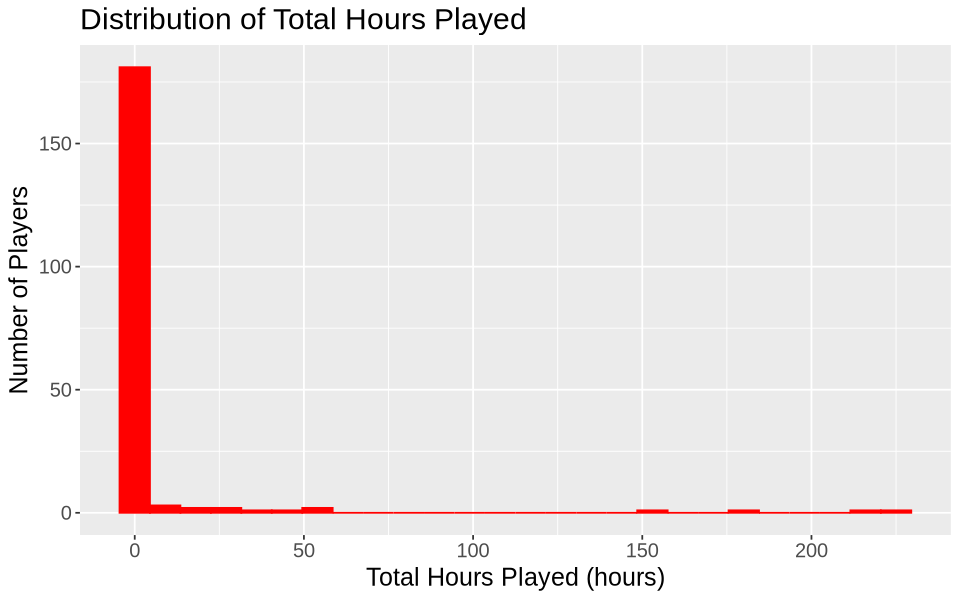

In [25]:
options(repr.plot.width = 8, repr.plot.height = 5) 
players |> ggplot(aes(x = played_hours)) +
  geom_histogram(binwidth = 9, fill = "red", color = "red") +
  labs(title = "Distribution of Total Hours Played",
    x = "Total Hours Played (hours)",
    y = "Number of Players") + theme(text = element_text(size = 15))

The right-skewed distribution shows that the majority of players spent under an hour, while a small, highly engaged group played much longer. Therefore, using the 85th percentile of hours played is an appropriate threshold for defining "avid players".

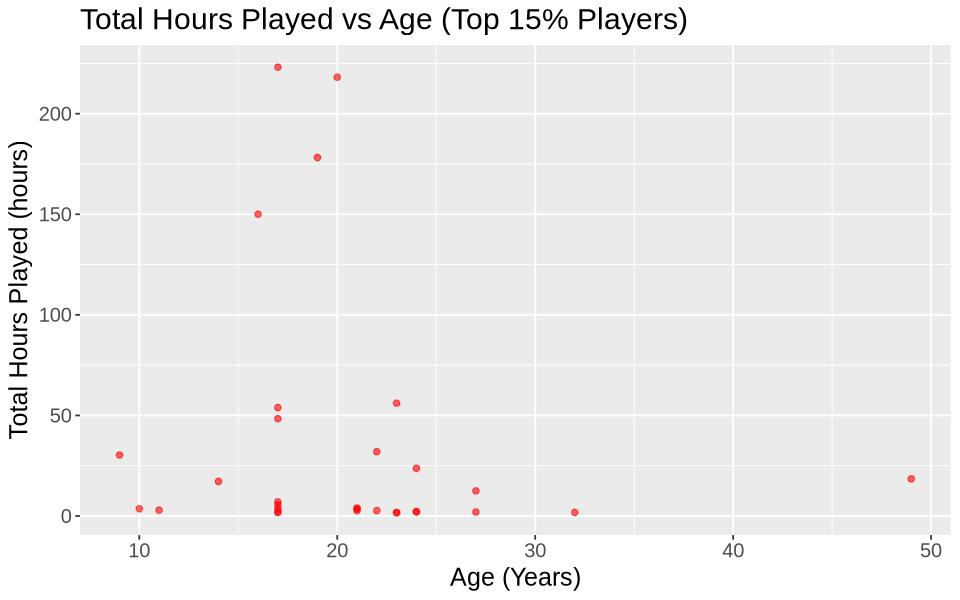

In [23]:
# filtering to only include high hour counts
avid_players <- players_0 |> filter(top_hours == TRUE)


avid_players |>
  ggplot(aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.5, color = "red") +
  labs(title = "Total Hours Played vs Age (Top 15% Players)",
    x = "Age (Years)",
    y = "Total Hours Played (hours)") + theme(text = element_text(size = 15))

Most top players are under 20, and this group shows the widest range of total playtime. The large variation in hours among younger players suggests that some are willing to dedicate significantly more time to the game than others.

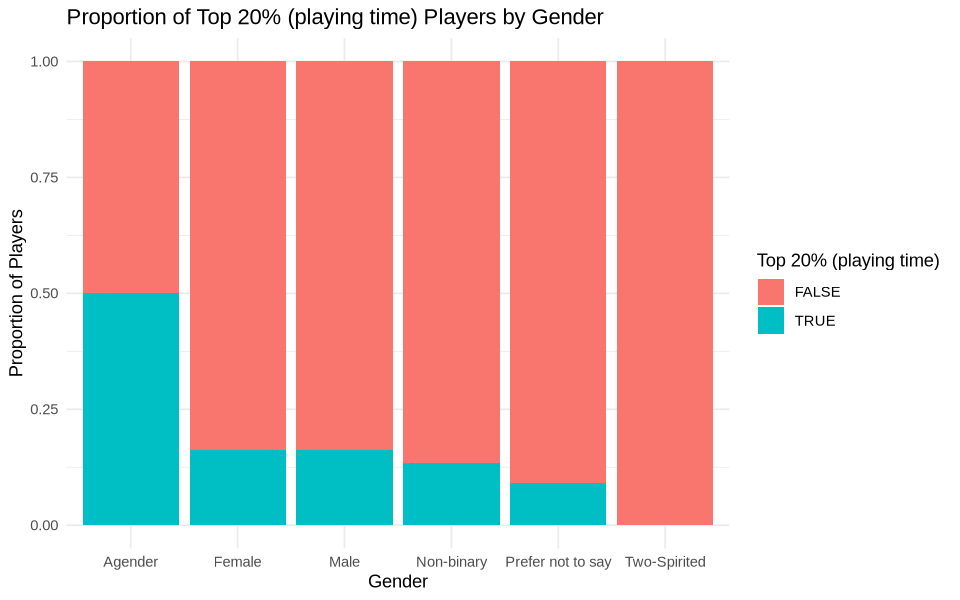

In [17]:
players_0 |> ggplot(aes(x = gender, fill = factor(top_hours))) + geom_bar(position = "fill") + 
labs(title = "Proportion of Top 20% (playing time) Players by Gender",
     x = "Gender",
     y = "Proportion of Players", 
     fill = "Top 20% (playing time)") + theme_minimal()

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


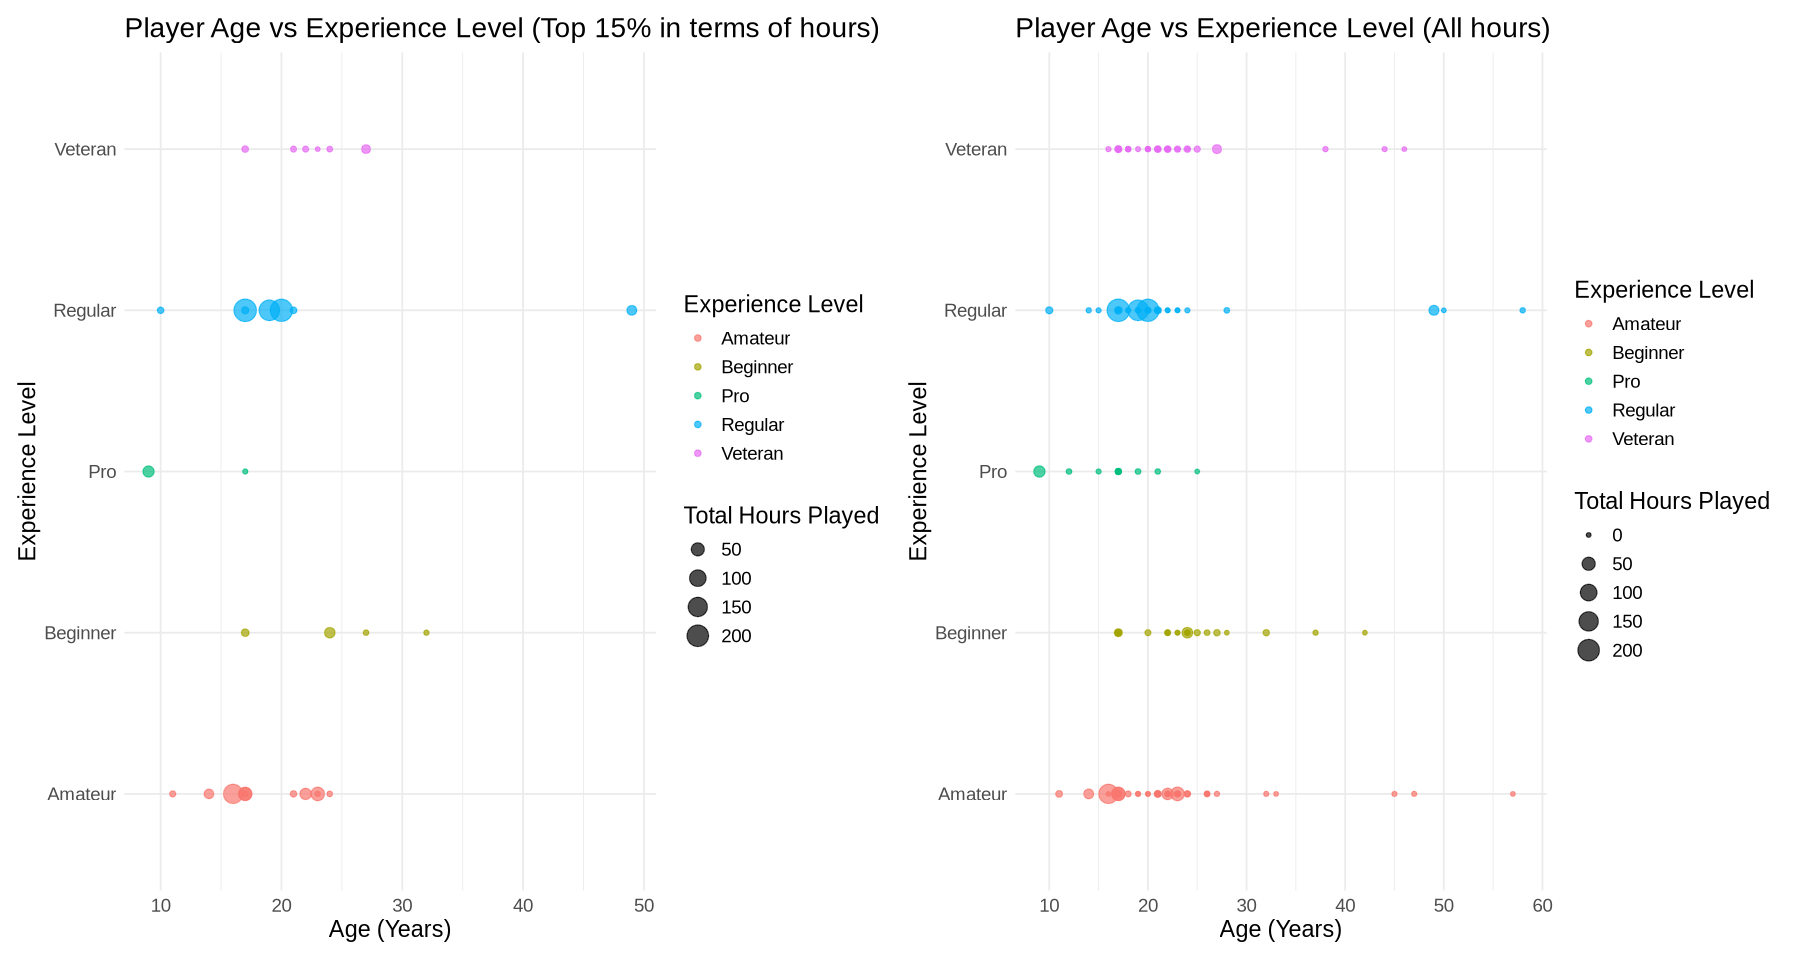

In [38]:
library(ggplot2)
library(patchwork)
options(repr.plot.width = 15, repr.plot.height = 8) 
g1 <- avid_players |>
  ggplot(aes(x = Age, y = experience, size = played_hours, color = experience)) +
  geom_point(alpha = 0.7) +
  labs(title = "Player Age vs Experience Level (Top 15% in terms of hours)",
    x = "Age (Years)",
    y = "Experience Level",
    size = "Total Hours Played",
    color = "Experience Level") +
  theme_minimal() +
  theme(text = element_text(size = 14))

g2 <- players |>
  ggplot(aes(x = Age, y = experience, size = played_hours, color = experience)) +
  geom_point(alpha = 0.7) +
  labs(title = "Player Age vs Experience Level (All hours)",
    x = "Age (Years)",
    y = "Experience Level",
    size = "Total Hours Played",
    color = "Experience Level") +
  theme_minimal() +
  theme(text = element_text(size = 14))

g1 + g2

An interesting finding is that younger players with **Regular** or **Amateur** experience levels tend to spend significantly more hours playing. This contrasts with the expectation that more experienced players, such as **Pros** or **Veterans**, would show the highest engagement.

## (4) Methods and Plan

The KNN Classification method would be suitable to answer our specific question.

KNN is a good fit because it predicts whether a player is an avid player by comparing them to others with similar characteristics. Since we also found that player engagement is likely influenced by age, experience level, or a combination of both, KNN can capture these patterns effectively. For example, if a 16-year-old Amateur player shares traits with other young players who are avid players, KNN will likely predict that this player is also an avid player.

Some assumptions that we have to keep in mind are:
- Variables are properly scaled so that no features "dominates" the distance calculation.